<a href="https://colab.research.google.com/github/thanakorn415/ClassWorkAi/blob/main/Predictive_Maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
from google.colab import files #using this to choose a csv file from my local directory
uploaded = files.upload() #running both of these lines will open the below prompt to execute above code

Saving predictive_maintenance.csv to predictive_maintenance (4).csv


In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype, is_numeric_dtype
import sklearn
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier


In [92]:
project_df = pd.read_csv("predictive_maintenance.csv")
project_df.head() #to check first 5 rows of the dataset

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [93]:
project_df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [94]:
project_df.isnull().sum() #to check the number of missing values if any, none found in this

,0
UDI,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
Target,0
Failure Type,0


Checking for Correlation

In [95]:
# Select only numeric columns for correlation calculation
numeric_project_df = project_df.select_dtypes(include=['number'])

corrMatrix = numeric_project_df.corr()

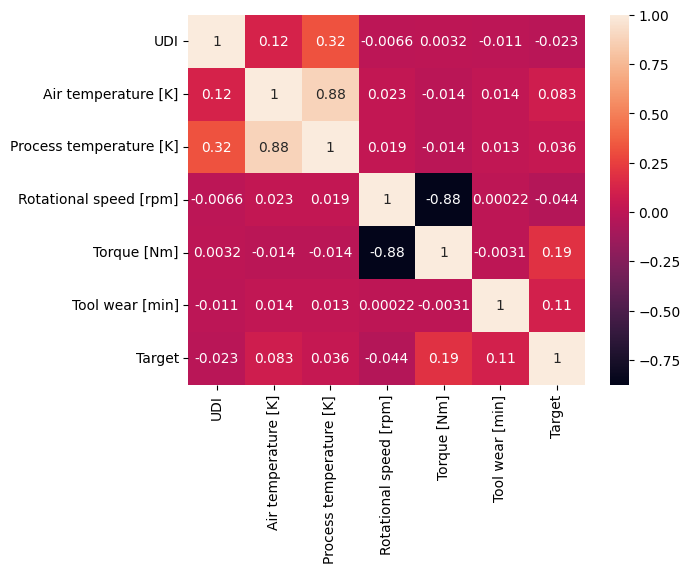

In [96]:
sns.heatmap(corrMatrix, annot = True)
plt.show()

From the correlation heatmap we can see that rotational speed and torque have a very high negative correlation. This is because they both are inversely related to each other. It is also seen that air temperature and process temperature are highly positively correlated. As the process temperature increases the surrounding temperature would increase too.

In [97]:
cols_not_required = [0,1,9] #removing the UDI, Product ID and Failure Type columns


In [98]:
project_df.drop(project_df.columns[cols_not_required], axis = 1, inplace = True) #dropping those columns
project_df.head() #to check first 5 rows of the dataset

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


In [99]:
project_new_df = pd.get_dummies(project_df, columns=['Type'])#creating dummy variables for Type column
project_new_df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,False,False,True
1,298.2,308.7,1408,46.3,3,0,False,True,False
2,298.1,308.5,1498,49.4,5,0,False,True,False
3,298.2,308.6,1433,39.5,7,0,False,True,False
4,298.2,308.7,1408,40.0,9,0,False,True,False


In [100]:
project_new_df['Power [kW]'] = (project_new_df['Rotational speed [rpm]'] * project_new_df['Torque [Nm]'])/9.5488 #merging the rotational speed and torque column by creating extra power column in kilowatts(unit).
project_new_df.head()


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Type_H,Type_L,Type_M,Power [kW]
0,298.1,308.6,1551,42.8,0,0,False,False,True,6951.952078
1,298.2,308.7,1408,46.3,3,0,False,True,False,6827.077748
2,298.1,308.5,1498,49.4,5,0,False,True,False,7749.790550
3,298.2,308.6,1433,39.5,7,0,False,True,False,5927.812919
4,298.2,308.7,1408,40.0,9,0,False,True,False,5898.123324


In [101]:
col_new = [2,3] #removing the torque and rotational speed columns as power is already created
project_new_df.drop(project_new_df.columns[col_new], axis = 1, inplace = True)
project_new_df.head()

,Air temperature [K],Process temperature [K],Tool wear [min],Target,Type_H,Type_L,Type_M,Power [kW]
0,298.1,308.6,0,0,False,False,True,6951.952078
1,298.2,308.7,3,0,False,True,False,6827.077748
2,298.1,308.5,5,0,False,True,False,7749.790550
3,298.2,308.6,7,0,False,True,False,5927.812919
4,298.2,308.7,9,0,False,True,False,5898.123324


In [102]:
air_col = [0]#removing the air temperature column too.
project_new_df.drop(project_new_df.columns[air_col], axis = 1, inplace = True)
project_new_df.head()

,Process temperature [K],Tool wear [min],Target,Type_H,Type_L,Type_M,Power [kW]
0,308.6,0,0,False,False,True,6951.952078
1,308.7,3,0,False,True,False,6827.077748
2,308.5,5,0,False,True,False,7749.790550
3,308.6,7,0,False,True,False,5927.812919
4,308.7,9,0,False,True,False,5898.123324


In [103]:
project_new_df.info()#checking the data types of the columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Process temperature [K]  10000 non-null  float64
 1   Tool wear [min]          10000 non-null  int64  
 2   Target                   10000 non-null  int64  
 3   Type_H                   10000 non-null  bool   
 4   Type_L                   10000 non-null  bool   
 5   Type_M                   10000 non-null  bool   
 6   Power [kW]               10000 non-null  float64
dtypes: bool(3), float64(2), int64(2)
memory usage: 341.9 KB


In [104]:
column_names = ["Process temperature [K]", "Tool wear [min]", "Type_H", "Type_L", "Type_M","Power [kW]", "Target"]
#rearranging the columns to put target in the end

In [105]:
project_new_df = project_new_df.reindex(columns = column_names)

project_new_df.head()

,Process temperature [K],Tool wear [min],Type_H,Type_L,Type_M,Power [kW],Target
0,308.6,0,False,False,True,6951.952078,0
1,308.7,3,False,True,False,6827.077748,0
2,308.5,5,False,True,False,7749.790550,0
3,308.6,7,False,True,False,5927.812919,0
4,308.7,9,False,True,False,5898.123324,0


In [106]:
X = project_new_df.iloc[:,:-1]#selecting all columns before the last one using ":-1"
y = project_new_df['Target']#output target vector


In [107]:
from sklearn.model_selection import train_test_split #loading the library for splitting the dataset into training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6700, 6) (3300, 6) (6700,) (3300,)


Classification Techniques and performance measures:-

1. **Logistic Regression**

In [108]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(max_iter = 300)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

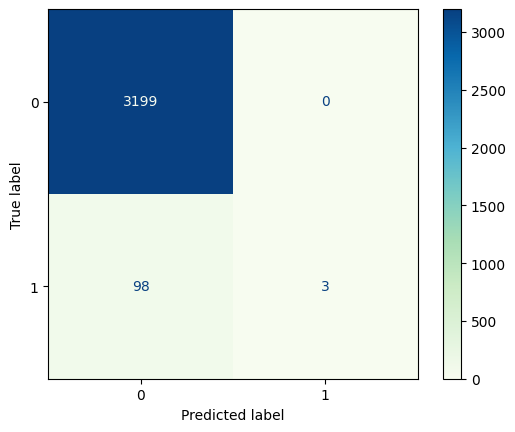

In [109]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay # Import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score # Explicitly import accuracy_score

# Use ConfusionMatrixDisplay.from_estimator instead of metrics.plot_confusion_matrix
confusion_matrix_display = ConfusionMatrixDisplay.from_estimator(reg, X_test, y_test, cmap = "GnBu")

# You can print the display object, which will show information about the plot
print(confusion_matrix_display)

In [110]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
log_score = accuracy_score(y_test,y_pred) * 100

Accuracy: 0.9703030303030303


AUC: 0.79


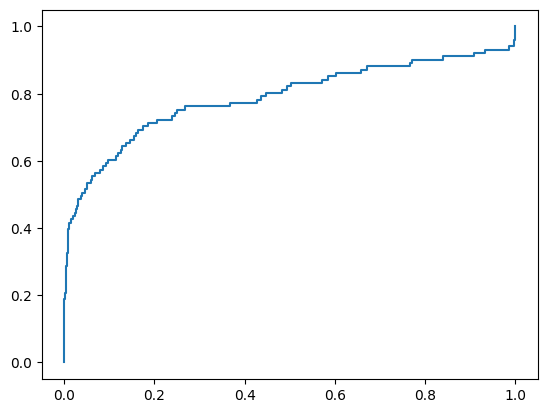

In [111]:
y_pred_prob = reg.predict_proba(X_test)[:,-1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr,tpr)

auc = metrics.roc_auc_score(y_test, y_pred_prob)
print("AUC:", round(auc,2))

2. **Classification Tree**

In [112]:
prmtcc_model = DecisionTreeClassifier(max_depth=6,max_leaf_nodes=6)
prmtcc_model

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=6)

In [113]:
prmtcc_model = prmtcc_model.fit(X_train,y_train)

In [114]:
y_predict11 = prmtcc_model.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_predict11))
class_score = accuracy_score(y_test,y_predict11) * 100

0.9812121212121212


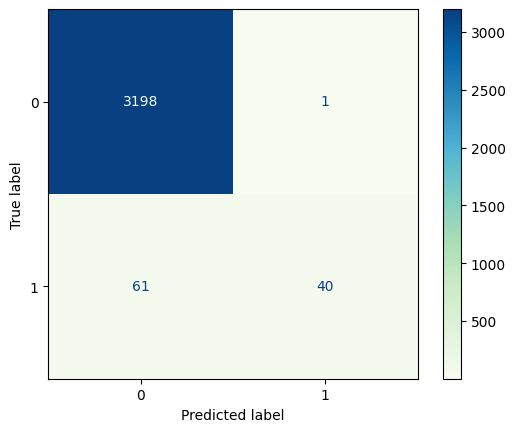

In [115]:
# Use ConfusionMatrixDisplay.from_estimator instead of metrics.plot_confusion_matrix
# Make sure ConfusionMatrixDisplay is imported if it wasn't already
from sklearn.metrics import ConfusionMatrixDisplay

# Create the ConfusionMatrixDisplay object
confusion_matrix_display2 = ConfusionMatrixDisplay.from_estimator(prmtcc_model, X_test, y_test, cmap = "GnBu")

# You can print the display object, which will show information about the plot
print(confusion_matrix_display2)

3. **Random Forest**

In [116]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=100, max_depth=2,random_state = 0)
RF.fit(X_train, y_train)
#RF.predict(X_test)
#round(RF.score(X_train,y_train), 4)

RandomForestClassifier(max_depth=2, random_state=0)

In [117]:
y_predict2 = RF.predict(X_test)
from sklearn.metrics import accuracy_score
print(round(accuracy_score(y_test,y_predict2),4))
randf_score = accuracy_score(y_test,y_predict2) * 100

0.9764


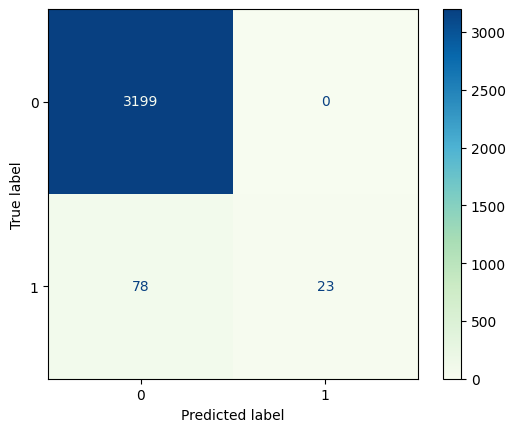

In [118]:
# Use ConfusionMatrixDisplay.from_estimator instead of metrics.plot_confusion_matrix
# Make sure ConfusionMatrixDisplay is imported if it wasn't already
from sklearn.metrics import ConfusionMatrixDisplay

# Create the ConfusionMatrixDisplay object using ConfusionMatrixDisplay.from_estimator
confusion_matrix3 = ConfusionMatrixDisplay.from_estimator(RF, X_test, y_test, cmap = "GnBu")

# You can print the display object, which will show information about the plot
print(confusion_matrix3)

4. **Neural Network**

In [119]:
from sklearn.neural_network import MLPClassifier

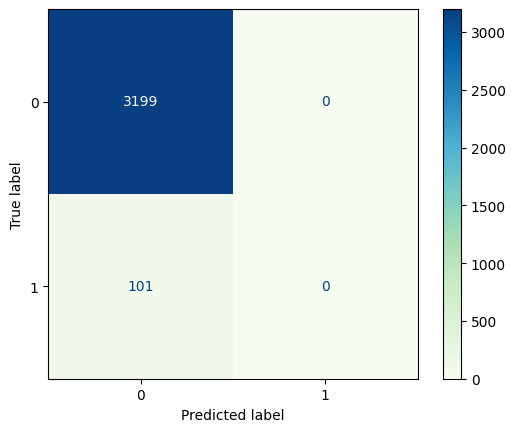

In [120]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay # Ensure ConfusionMatrixDisplay is imported

pr_mt_nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,2), random_state=1)
pr_mt_nn.fit(X_train, y_train)

# Use ConfusionMatrixDisplay.from_estimator instead of metrics.plot_confusion_matrix
confusion_matrix4 = ConfusionMatrixDisplay.from_estimator(pr_mt_nn, X_test, y_test, cmap = "GnBu")

print(confusion_matrix4)

In [121]:
y_predict3 = pr_mt_nn.predict(X_test)
round(accuracy_score(y_test,y_predict3),4)
print(round(accuracy_score(y_test,y_predict3),4))
nn_score = accuracy_score(y_test,y_predict3) * 100

0.9694


In [122]:
summary_1 = {'Classification algorithms' : ['Logistic Regression','Classification Tree', 'Random Forest', 'Neural Network'],
             'Accuracy': [log_score, class_score, randf_score, nn_score]}

summary_df = pd.DataFrame(summary_1)
print(summary_df)

  Classification algorithms   Accuracy
0       Logistic Regression  97.030303
1       Classification Tree  98.121212
2             Random Forest  97.636364
3            Neural Network  96.939394


**Classification Tree** has the highest accuracy amongst the 4.